Open CSV then 
- create a _clean copy 
- remove rows that don't have a value in column `predicted_conversion_factor_cm`
- remove images that have an `image_height` less than 3000 
    - this is a limitation of the CF predictor, it significantly overestimates for small images, can fix later
- remove duplicate `component_name` rows
    - if more than one ruler was located, there will be more than one row for the same leaf
    - logic is
        - if only 1 row has a value then keep the row that has `conversion_mean` value 
        - if more than 1 row has a `conversion_mean` value, average them, keep the first row of that component with the averaged `conversion_mean` and delete the other duplicate rows
        - if there are no rows with a `conversion_mean`, just keep the first row


In [48]:
# file_path = "C:/Users/Will/Downloads/herbarium_CF_test/LM2_2024_09_17__15-17-36/Data/Measurements/LM2_2024_09_17__15-17-36_MEASUREMENTS.csv"
# outline_path = "C:/Users/Will/Downloads/herbarium_CF_test/LM2_2024_09_17__15-17-36/Keypoints/Simple_Labels"
# outline_path = "C:/Users/Will/Downloads/herbarium_CF_test/LM2_2024_09_17__15-17-36/Keypoints/Simple_Labels_Original"

### 2500 images 50 spp
# file_path = "C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Data/Measurements/LM2_2024_09_18__07-52-47_MEASUREMENTS.csv"
# outline_path = "C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Keypoints/Simple_Labels"

### 2000 images from Cornales
file_path = "D:/D_Desktop/LM2_parallel_test_2000_Cornales/LM2_MEASUREMENTS.csv"
outline_path = "D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels"


In [49]:
import pandas as pd

def preprocessing(file_path):
    # Step 1: Load the CSV into a Pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Step 2: Create a copy of the original data for safe cleaning
    df_clean = df.copy()

    # Step 3: Remove rows where 'predicted_conversion_factor_cm' is missing
    df_clean = df_clean.dropna(subset=['predicted_conversion_factor_cm'])

    # Step 4: Remove rows where 'image_height' is less than 3000
    df_clean = df_clean[df_clean['image_height'] >= 3000]

    # Step 5: Handle duplicates in 'component_name'
    def handle_duplicates(group):
        # Filter out rows where conversion_mean is NaN or 0
        valid_conversion_mean = group[(group['conversion_mean'].notna()) & (group['conversion_mean'] != 0)]
        
        # Case 1: If there's only one valid row with a 'conversion_mean', keep that row
        if len(valid_conversion_mean) == 1:
            return valid_conversion_mean
        
        # Case 2: If more than one valid row has 'conversion_mean', average those and keep the first row
        if len(valid_conversion_mean) > 1:
            avg_conversion_mean = valid_conversion_mean['conversion_mean'].mean()
            first_row = group.iloc[0].copy()  # Get a copy of the first row to modify
            first_row['conversion_mean'] = avg_conversion_mean  # Update with the averaged value
            return pd.DataFrame([first_row])  # Return the updated first row as a DataFrame
        
        # Case 3: If no valid rows have 'conversion_mean', just keep the first row of the group
        return group.iloc[[0]]
    
    # Apply the deduplication logic to each group of duplicates in 'component_name'
    df_clean = df_clean.groupby('component_name', group_keys=False).apply(handle_duplicates)

    # Step 6: Return the cleaned DataFrame
    return df_clean


In [50]:
# Usage in Jupyter Notebook
cleaned_df = preprocessing(file_path)

# Display the cleaned data (first 5 rows) to check
print(cleaned_df.head())

# Show the number of rows in the cleaned DataFrame
print(f"Number of rows after cleaning: {cleaned_df.shape[0]}")

                                     filename  image_height  image_width  \
43   UM_1848867164_Cornaceae_Cornus_sanguinea          5000         3456   
75   UM_1848867164_Cornaceae_Cornus_sanguinea          5000         3456   
2    UM_1848867164_Cornaceae_Cornus_sanguinea          5000         3456   
25   UM_1848867164_Cornaceae_Cornus_sanguinea          5000         3456   
149  UM_1848867164_Cornaceae_Cornus_sanguinea          5000         3456   

                                        component_name  conversion_mean  \
43   UM_1848867164_Cornaceae_Cornus_sanguinea__L__1...              0.0   
75   UM_1848867164_Cornaceae_Cornus_sanguinea__L__1...              0.0   
2    UM_1848867164_Cornaceae_Cornus_sanguinea__L__1...              0.0   
25   UM_1848867164_Cornaceae_Cornus_sanguinea__L__1...              0.0   
149  UM_1848867164_Cornaceae_Cornus_sanguinea__L__1...              0.0   

     predicted_conversion_factor_cm  area  perimeter  convex_hull  \
43                     

C:\Users\Will\AppData\Local\Temp\ipykernel_39164\2911864284.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('component_name', group_keys=False).apply(handle_duplicates)


Add helper columns
- split up `component_name` by "__" first
        TI_2005765760_Urticaceae_Pilea_pumila__L__1092-482-1285-855
    - becomes
        variable "to_split", will use in a moment: TI_2005765760_Urticaceae_Pilea_pumila
        column `component_type`: L
        column `component_id`: 1092-482-1285-855
    - then with "to_split" split by "_":
        column `herb`: to_split[0]
        column `gbif_id`: to_split[1]
        column `fullname`: to_split[2] + to_split[3] + to_split[4]
        column `genus_species`: to_split[3] + to_split[4]
        column `family`: to_split[2]
        column `genus`: to_split[3]
        column `specific_epithet`: to_split[4]
- conversion factor error
    - if both values are present, calcualte the error (the calculated `conversion_mean` could still be wrong though)

In [51]:
def add_helper_columns(df):
    # Step 1: Split 'component_name' by "__" first
    split_component = df['component_name'].str.split("__", expand=True)
    
    # The first part before "__" will be the variable "to_split"
    df['to_split'] = split_component[0]
    
    # 'component_type' and 'component_id' come from the second part of the split
    df['component_type'] = split_component[1]
    df['component_id'] = split_component[2]
    
    # Step 2: Split "to_split" further by "_"
    split_to_split = df['to_split'].str.split("_", expand=True)

    # Assigning new columns based on the parsed parts
    df['herb'] = split_to_split[0]
    df['gbif_id'] = split_to_split[1]
    df['fullname'] = split_to_split[2] + "_" + split_to_split[3] + "_" + split_to_split[4]
    df['genus_species'] = split_to_split[3] + "_" + split_to_split[4]
    df['family'] = split_to_split[2]
    df['genus'] = split_to_split[3]
    df['specific_epithet'] = split_to_split[4]

    # Return the DataFrame with the new columns added
    return df

def add_cf_error_column(df):
    # Step to compute cf_error similar to the Excel formula
    df['cf_error'] = df.apply(lambda row: "" if (1 - (row['conversion_mean'] / row['predicted_conversion_factor_cm']) == 1) 
                              else 1 - (row['conversion_mean'] / row['predicted_conversion_factor_cm']), axis=1)
    
    # Return the updated DataFrame
    return df

In [52]:
# Add the helper columns
cleaned_df = add_helper_columns(cleaned_df)

# Add cf_error column
cleaned_df = add_cf_error_column(cleaned_df)

# Display the updated DataFrame
cleaned_df.head()

# Display the rows that have non-empty cf_error values
filtered_df = cleaned_df[cleaned_df['cf_error'] != ""]

# Show the filtered rows with cf_error values
filtered_df.head()

,filename,image_height,image_width,component_name,conversion_mean,predicted_conversion_factor_cm,area,perimeter,convex_hull,bbox,...,component_type,component_id,herb,gbif_id,fullname,genus_species,family,genus,specific_epithet,cf_error
519,UM_1848873777_Cornaceae_Cornus_sanguinea,5000,3463,UM_1848873777_Cornaceae_Cornus_sanguinea__L__1...,110.093705,110.862403,1.23,0.06,1.86,"[[34, 6], [337, 6], [337, 161], [34, 161]]",...,L,1409-1651-1756-1856,UM,1848873777,Cornaceae_Cornus_sanguinea,Cornus_sanguinea,Cornaceae,Cornus,sanguinea,0.006934
574,UM_1848873777_Cornaceae_Cornus_sanguinea,5000,3463,UM_1848873777_Cornaceae_Cornus_sanguinea__L__1...,110.093705,110.862403,2.57,0.09,3.96,"[[11, 13], [383, 13], [383, 245], [11, 245]]",...,L,1854-2428-2252-2737,UM,1848873777,Cornaceae_Cornus_sanguinea,Cornus_sanguinea,Cornaceae,Cornus,sanguinea,0.006934
563,UM_1848873777_Cornaceae_Cornus_sanguinea,5000,3463,UM_1848873777_Cornaceae_Cornus_sanguinea__L__2...,110.093705,110.862403,4.16,0.08,4.45,"[[16, 11], [416, 11], [416, 211], [16, 211]]",...,L,295-1633-779-1855,UM,1848873777,Cornaceae_Cornus_sanguinea,Cornus_sanguinea,Cornaceae,Cornus,sanguinea,0.006934
451,UM_1848873777_Cornaceae_Cornus_sanguinea,5000,3463,UM_1848873777_Cornaceae_Cornus_sanguinea__L__5...,110.093705,110.862403,10.13,0.12,10.47,"[[27, 25], [442, 25], [442, 472], [27, 472]]",...,L,516-2330-998-2830,UM,1848873777,Cornaceae_Cornus_sanguinea,Cornus_sanguinea,Cornaceae,Cornus,sanguinea,0.006934
547,UM_1848873777_Cornaceae_Cornus_sanguinea,5000,3463,UM_1848873777_Cornaceae_Cornus_sanguinea__L__5...,110.093705,110.862403,1.87,0.06,2.14,"[[11, 9], [272, 9], [272, 170], [11, 170]]",...,L,556-3334-886-3517,UM,1848873777,Cornaceae_Cornus_sanguinea,Cornus_sanguinea,Cornaceae,Cornus,sanguinea,0.006934


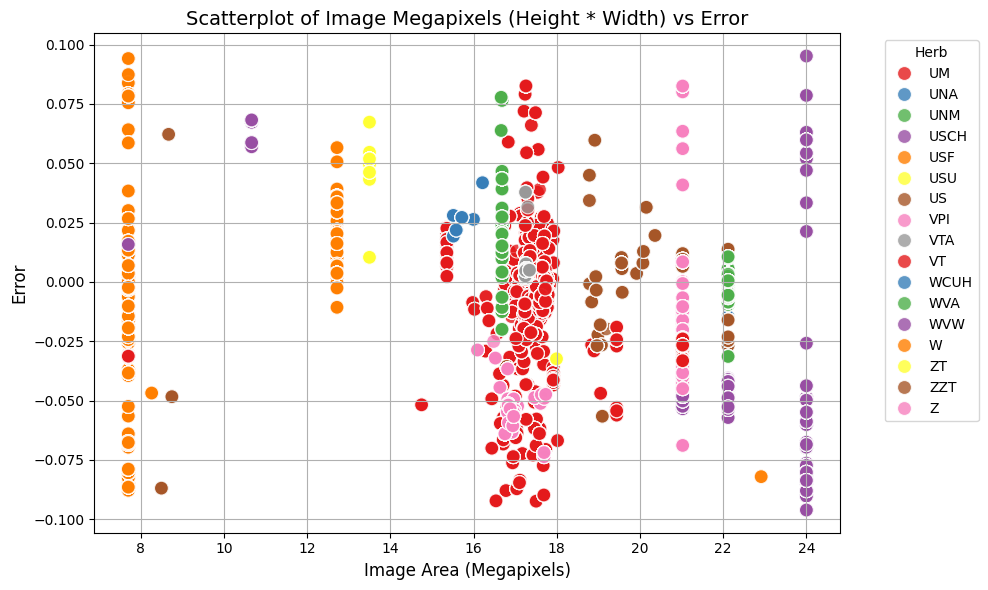

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a new column for image_area (image_height * image_width)
cleaned_df['megapixels'] = cleaned_df['image_height'] * cleaned_df['image_width'] / 1000000

# Step 2: Convert cf_error to numeric, forcing errors to NaN (this will handle empty strings)
cleaned_df['cf_error'] = pd.to_numeric(cleaned_df['cf_error'], errors='coerce')

# Step 3: Filter out rows where cf_error is NaN (invalid for plotting)
filtered_df = cleaned_df.dropna(subset=['cf_error'])

# Step 4: Set up the plot
plt.figure(figsize=(10, 6))

# Step 5: Create the scatter plot
scatter = sns.scatterplot(
    data=filtered_df,
    x='megapixels',
    y='cf_error',
    hue='herb',  # Color by herb
    palette='Set1',  # Use a color palette (optional, but Set1 works well for categories)
    s=100,  # Size of the points
    alpha=0.8  # Transparency of points
)

# Step 6: Add labels and a title
plt.title("Scatterplot of Image Megapixels (Height * Width) vs Error", fontsize=14)
plt.xlabel("Image Area (Megapixels)", fontsize=12)
plt.ylabel("Error", fontsize=12)

# Step 7: Show legend and grid
plt.legend(title='Herb', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Step 8: Display the plot
plt.tight_layout()
plt.show()


In [54]:
# Ensure cf_error is numeric, as before
cleaned_df['cf_error'] = pd.to_numeric(cleaned_df['cf_error'], errors='coerce')

# Filter rows where cf_error is greater than 2
filtered_cf_error_gt_2 = cleaned_df[cleaned_df['cf_error'] > 0.2]

# Display the rows where cf_error is greater than 2
filtered_cf_error_gt_2

,filename,image_height,image_width,component_name,conversion_mean,predicted_conversion_factor_cm,area,perimeter,convex_hull,bbox,...,component_id,herb,gbif_id,fullname,genus_species,family,genus,specific_epithet,cf_error,megapixels


Now we know which leaves to use in our outline data
    - go to `outline_path` and get outlines of our leaves in cleaned_df['component_name']



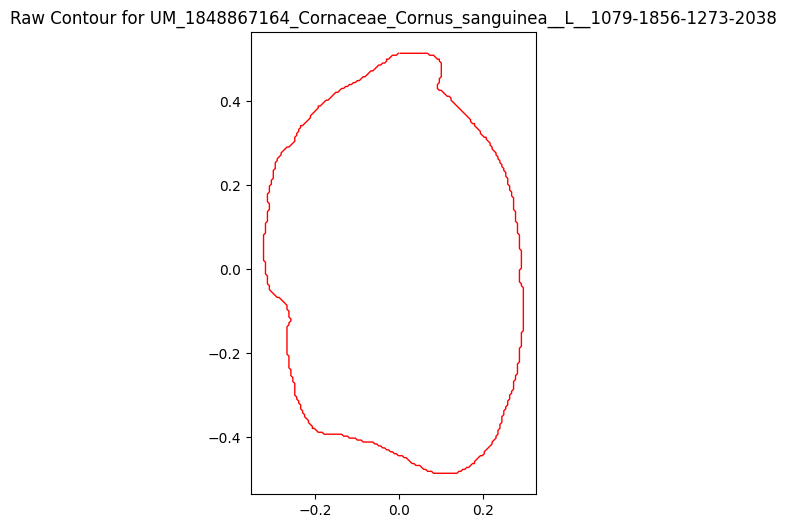

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the outline path

# Function to read and visualize the first contour without transformations
def visualize_first_contour_raw(component_name):
    # Build the path to the .txt file for the given component
    txt_file_path = os.path.join(outline_path, f'{component_name}.txt')
    
    if not os.path.exists(txt_file_path):
        print(f"File not found: {txt_file_path}")
        return
    
    # Read the data from the file
    with open(txt_file_path, 'r') as file:
        lines = file.readlines()

    # Starting from line 11, parse the points (x, y)
    points = []
    for line in lines[11:]:
        x_str, y_str = line.strip().split(',')
        x = float(x_str)
        y = float(y_str)
        points.append((x, y))

    # Convert to a NumPy array for plotting
    points_np = np.array(points, dtype=np.float32)

    # Plot the raw contour points
    plt.figure(figsize=(6, 6))
    plt.plot(points_np[:, 0], points_np[:, 1], 'r-', linewidth=1)
    plt.title(f'Raw Contour for {component_name}')
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal
    plt.show()

# Visualize the raw contour for the first component in cleaned_df
first_component_name = cleaned_df['component_name'].iloc[0]
visualize_first_contour_raw(first_component_name)


See what genera are available

In [64]:
import json
def parse_availability(df):
    # Create a dictionary to hold the unique values
    unique_values = {
        'family': set(),
        'genus': set(),
        'genus_species': set(),
        'fullname': set()
    }
    
    # Iterate over the rows of the DataFrame to collect unique values
    for _, row in df.iterrows():
        unique_values['family'].add(row['family'])
        unique_values['genus'].add(row['genus'])
        unique_values['genus_species'].add(row['genus_species'])
        unique_values['fullname'].add(row['fullname'])
    
    # Convert sets back to lists for easier consumption
    for key in unique_values:
        unique_values[key] = list(unique_values[key])
    
    return unique_values

# Use the function with the cleaned_df
unique_data = parse_availability(cleaned_df)

# Display the dictionary of unique values
print(json.dumps(unique_data, indent=4))

{
    "family": [
        "Cornaceae"
    ],
    "genus": [
        "Toricellia",
        "Alangium",
        "Cornus"
    ],
    "genus_species": [
        "Cornus_peruviana",
        "Alangium_platanifolium",
        "Alangium_salviifolium",
        "Cornus_iberica",
        "Cornus_kousa",
        "Cornus_nuttallii",
        "Cornus_florida",
        "Cornus_hemsleyi",
        "Cornus_stolonifera",
        "Cornus_floccosa",
        "Alangium_begoniifolium",
        "Cornus_nudiflora",
        "Cornus_circinnata",
        "Cornus_sanguinea",
        "Cornus_latifolia",
        "Alangium_chinense",
        "Cornus_obliqua",
        "Cornus_officinalis",
        "Cornus_coerulea",
        "Cornus_suecica",
        "Cornus_sibirica",
        "Cornus_japonica",
        "Cornus_drummondii",
        "Cornus_australis",
        "Cornus_herbacea",
        "Cornus_stricta",
        "Alangium_javanicus",
        "Cornus_purpusii",
        "Alangium_jasminiflora",
        "Cornus_hongkongensis

Visualize the normalized contours based on a filter

File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_2573014240_Cornaceae_Cornus_canadensis__L__348-2396-1429-3593.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970637047_Cornaceae_Cornus_canadensis__L__289-1793-1111-2526.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970637047_Cornaceae_Cornus_canadensis__L__813-1294-1599-2341.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970670363_Cornaceae_Cornus_canadensis__L__1006-1972-3013-3035.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970674353_Cornaceae_Cornus_canadensis__L__1908-745-2824-2566.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970674353_Cornaceae_Cornus_canadensis__L__974-1732-1825-2569.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_4454140331_Cornaceae_Cornus_canadensis__L__744-375-1554-1

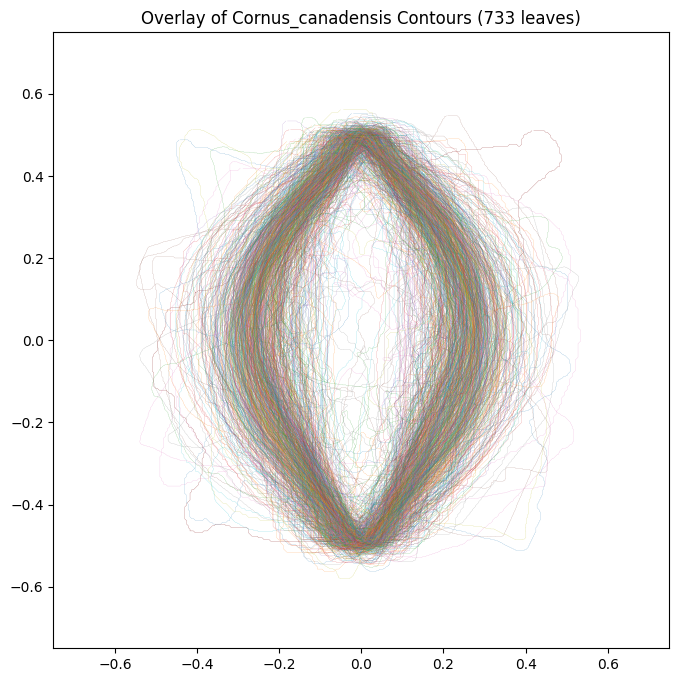

File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\USCH_1849125996_Cornaceae_Cornus_stricta__L__646-4167-1019-4699.txt


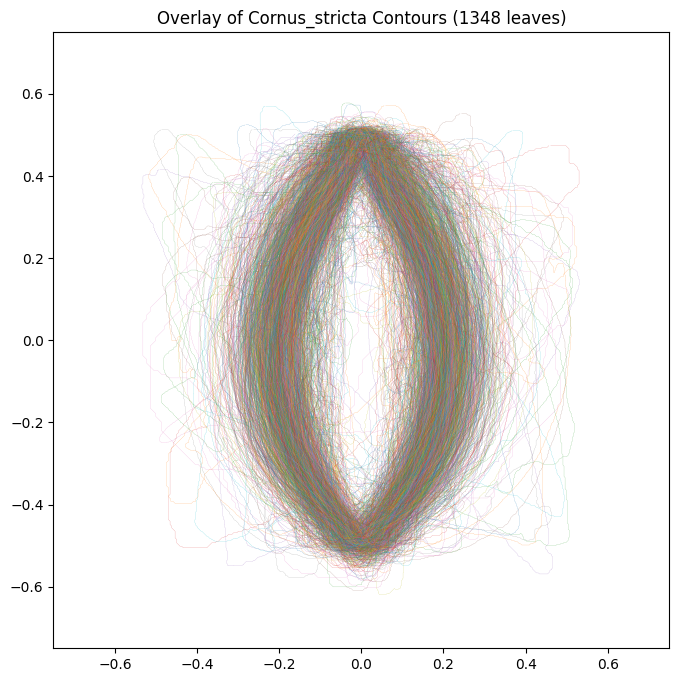

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the outline path


# Function to read and overlay multiple contours
def visualize_contours_overlay(df_subset, title_name):
    plt.figure(figsize=(8, 8))
    
    # Iterate through the subset and plot each contour
    for idx, row in df_subset.iterrows():
        component_name = row['component_name']
        txt_file_path = os.path.join(outline_path, f'{component_name}.txt')
        
        if not os.path.exists(txt_file_path):
            print(f"File not found: {txt_file_path}")
            continue

        # Read the data from the file
        with open(txt_file_path, 'r') as file:
            lines = file.readlines()

        # Starting from line 11, parse the points (x, y)
        points = []
        for line in lines[11:]:
            x_str, y_str = line.strip().split(',')
            x = float(x_str)
            y = float(y_str)
            points.append((x, y))

        # Convert to a NumPy array for plotting
        points_np = np.array(points, dtype=np.float32)

        # Plot the contour points
        plt.plot(points_np[:, 0], points_np[:, 1], linewidth=0.1)

    plt.title(f'Overlay of {title_name} Contours ({len(df_subset)} leaves)')
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal

    # Set both axes limits to -1 to 1
    plt.xlim([-0.75, 0.75])
    plt.ylim([-0.75, 0.75])
    
    plt.show()

# Function to filter cleaned_df based on user input and visualize
def overlay_outlines_by_filter(cleaned_df, family=None, genus=None, genus_species=None, fullname=None):
    df_subset = cleaned_df.copy()

    # Apply filtering based on input parameters
    if family:
        title_name = family
        df_subset = df_subset[df_subset['family'] == family]
    if genus:
        title_name = genus
        df_subset = df_subset[df_subset['genus'] == genus]
    if genus_species:
        title_name = genus_species
        df_subset = df_subset[df_subset['genus_species'] == genus_species]
    if fullname:
        title_name = fullname
        df_subset = df_subset[df_subset['fullname'] == fullname]

    # Check if any rows match the filter
    if df_subset.empty:
        print("No data matches the selected filter.")
        return

    # Visualize the contours for the filtered subset
    visualize_contours_overlay(df_subset, title_name)

# Example usage: Overlay all outlines for a given family
# Replace with your desired filter (family, genus, genus_species, fullname)
# overlay_outlines_by_filter(cleaned_df, family='Amaranthaceae')

# Other possible filters:
# overlay_outlines_by_filter(cleaned_df, genus='Quercus')
# overlay_outlines_by_filter(cleaned_df, genus='Acer')
# overlay_outlines_by_filter(cleaned_df, genus_species='Quercus_alba')
# overlay_outlines_by_filter(cleaned_df, genus_species='Quercus_glauca')
# overlay_outlines_by_filter(cleaned_df, fullname='Urticaceae_Pilea_pumila')

overlay_outlines_by_filter(cleaned_df, genus_species='Cornus_canadensis')
overlay_outlines_by_filter(cleaned_df, genus_species='Cornus_stricta')


Align by PCA

Skipping contour UM_1936459419_Cornaceae_Cornus_canadensis__L__1623-2914-1949-3111 due to misalignment: 46.58 degrees
Skipping contour UM_1936459452_Cornaceae_Cornus_canadensis__L__2309-1963-2754-2525 due to misalignment: 112.09 degrees
Skipping contour UM_1936459452_Cornaceae_Cornus_canadensis__L__586-2190-800-2418 due to insufficient points: 1 points
Skipping contour UM_1936459459_Cornaceae_Cornus_canadensis__L__794-3265-950-3425 due to misalignment: -10.14 degrees
Skipping contour UM_1936459471_Cornaceae_Cornus_canadensis__L__955-147-1394-688 due to misalignment: 63.33 degrees
Skipping contour UM_1936459489_Cornaceae_Cornus_canadensis__L__1805-2031-3008-3113 due to misalignment: -40.03 degrees
Skipping contour UM_1936488270_Cornaceae_Cornus_canadensis__L__1623-2914-1949-3111 due to misalignment: 46.58 degrees
Skipping contour US_2236044706_Cornaceae_Cornus_canadensis__L__886-1772-1026-1925 due to misalignment: 60.48 degrees
Skipping contour VPI_3893447546_Cornaceae_Cornus_canadensis

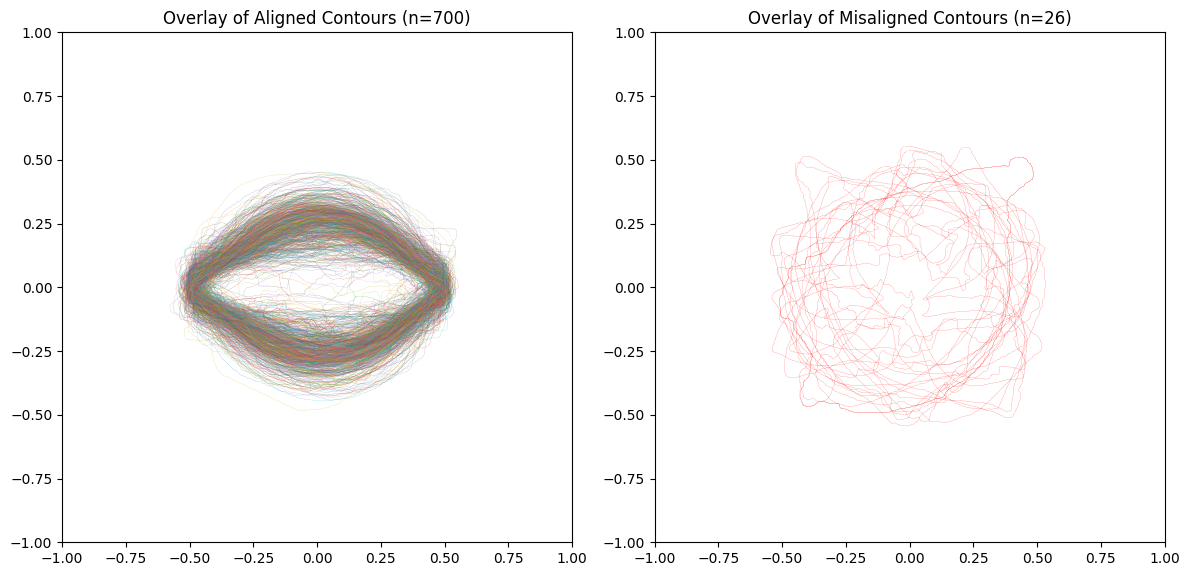

Skipping contour UM_1915443094_Cornaceae_Cornus_stricta__L__65-1450-752-1842 due to misalignment: 65.03 degrees
Skipping contour UM_1915443131_Cornaceae_Cornus_stricta__L__1766-2609-2171-2856 due to misalignment: 65.36 degrees
Skipping contour UNA_3744717435_Cornaceae_Cornus_stricta__L__1267-2334-1564-2945 due to misalignment: -41.78 degrees
Skipping contour UNA_3744717435_Cornaceae_Cornus_stricta__L__2537-1846-2862-1973 due to misalignment: 113.23 degrees
Skipping contour USCH_1849106753_Cornaceae_Cornus_stricta__L__1643-2111-1913-2544 due to misalignment: 115.96 degrees
Skipping contour USCH_1849106753_Cornaceae_Cornus_stricta__L__1994-805-2191-1118 due to misalignment: 52.08 degrees
Skipping contour USCH_1849118163_Cornaceae_Cornus_stricta__L__601-1129-1037-1325 due to insufficient points: 1 points
Skipping contour USCH_1849118361_Cornaceae_Cornus_stricta__L__1404-4128-1638-4596 due to insufficient points: 1 points
Skipping contour USCH_1849123419_Cornaceae_Cornus_stricta__L__352-12

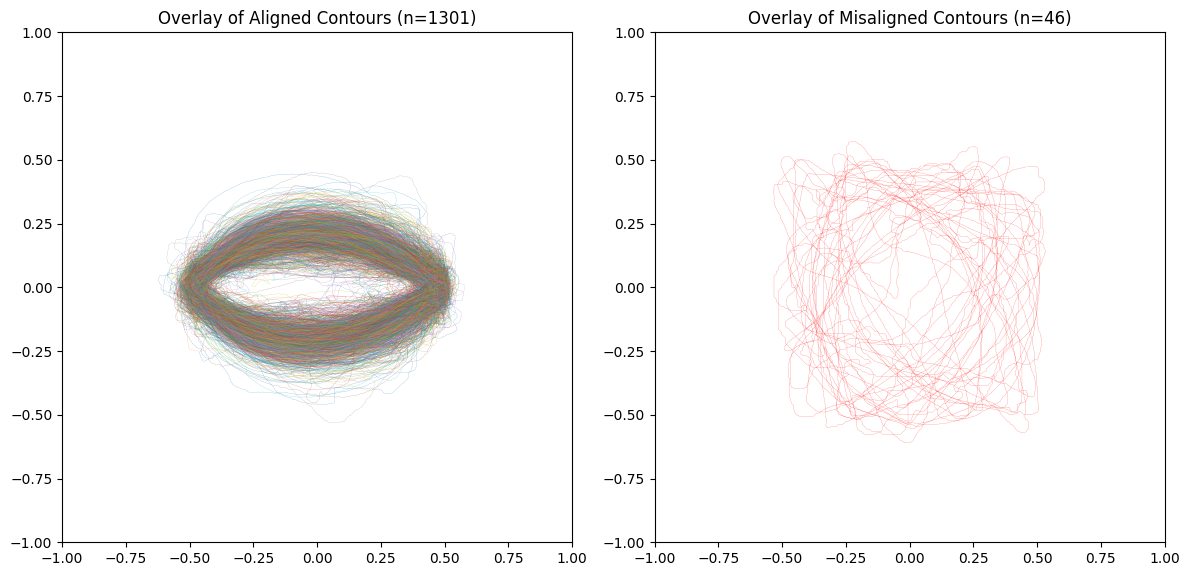

In [57]:
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_align(points_np, component_name, vertical_tolerance=15):
    # Check if there are enough points to perform PCA
    if len(points_np) < 2:
        print(f"Skipping contour {component_name} due to insufficient points: {len(points_np)} points")
        return None, None

    # Prepare the matrix X = [c, r].T for PCA
    c = points_np[:, 0]  # X coordinates (columns)
    r = points_np[:, 1]  # Y coordinates (rows)
    X = np.array([c, r]).T

    # Apply PCA to find the principal components
    pca = PCA(n_components=2)
    pca.fit(X)

    # Compute the angle between the first principal component and the x-axis
    angle = np.arctan2(pca.components_[0, 1], pca.components_[0, 0])
    angle_degrees = np.degrees(angle)

    # Ensure angle is between -180 and 180 degrees
    angle_degrees = (angle_degrees + 360) % 360
    if angle_degrees > 180:
        angle_degrees -= 360

    # Check if the alignment is near vertical (90 degrees or -90 degrees)
    if not (abs(angle_degrees - 90) <= vertical_tolerance or abs(angle_degrees + 90) <= vertical_tolerance):
        print(f"Skipping contour {component_name} due to misalignment: {angle_degrees:.2f} degrees")
        return None, angle_degrees

    # Rotation matrix to rotate points
    theta = np.radians(-angle_degrees)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    rotated_points = X @ rotation_matrix.T

    return rotated_points, angle_degrees

# Function to read and overlay multiple contours with PCA alignment
def visualize_contours_overlay_PCA(df_subset, alignment_threshold=15):
    # Create two subplots: one for aligned contours and one for misaligned ones
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    contours_aligned = []
    contours_misaligned = []

    # Iterate through the subset and process each contour
    for idx, row in df_subset.iterrows():
        component_name = row['component_name']
        txt_file_path = os.path.join(outline_path, f'{component_name}.txt')

        if not os.path.exists(txt_file_path):
            print(f"File not found: {txt_file_path}")
            continue

        # Read the data from the file
        with open(txt_file_path, 'r') as file:
            lines = file.readlines()

        # Starting from line 11, parse the points (x, y)
        points = []
        for line in lines[11:]:
            x_str, y_str = line.strip().split(',')
            x = float(x_str)
            y = float(y_str)
            points.append((x, y))

        # Convert to a NumPy array for plotting
        points_np = np.array(points, dtype=np.float32)

        # Perform PCA and align the points
        aligned_points, angle = pca_align(points_np, component_name, alignment_threshold)

        if aligned_points is None:
            # Store misaligned contour (contour that was skipped)
            contours_misaligned.append((points_np, angle))
        else:
            # Store aligned contour and angle for later sorting
            contours_aligned.append((aligned_points, abs(angle)))

    # Plot all aligned contours on the first subplot
    ax1.set_title(f'Overlay of Aligned Contours (n={len(contours_aligned)})')
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    
    for i, (aligned_points, angle) in enumerate(contours_aligned):
        ax1.plot(aligned_points[:, 0], aligned_points[:, 1], linewidth=0.1)
        if angle:
            print(f"Plotting aligned contour {i+1} with alignment angle: {angle:.2f} degrees")
        else:
            print(f"Plotting misaligned contour {i+1} with alignment angle: None ")

    # Plot all misaligned contours on the second subplot
    ax2.set_title(f'Overlay of Misaligned Contours (n={len(contours_misaligned)})')
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])

    for i, (misaligned_points, angle) in enumerate(contours_misaligned):
        ax2.plot(misaligned_points[:, 0], misaligned_points[:, 1], linewidth=0.1, color='r')
        if angle:
            print(f"Plotting misaligned contour {i+1} with alignment angle: {angle:.2f} degrees")
        else:
            print(f"Plotting misaligned contour {i+1} with alignment angle: None ")

    plt.tight_layout()
    plt.show()

# Function to filter cleaned_df based on user input and visualize
def overlay_outlines_by_filter_PCA(cleaned_df, family=None, genus=None, genus_species=None, fullname=None, alignment_threshold=15):
    df_subset = cleaned_df.copy()

    # Apply filtering based on input parameters
    if family:
        df_subset = df_subset[df_subset['family'] == family]
    if genus:
        df_subset = df_subset[df_subset['genus'] == genus]
    if genus_species:
        df_subset = df_subset[df_subset['genus_species'] == genus_species]
    if fullname:
        df_subset = df_subset[df_subset['fullname'] == fullname]

    # Check if any rows match the filter
    if df_subset.empty:
        print("No data matches the selected filter.")
        return

    # Visualize the aligned and misaligned contours for the filtered subset
    visualize_contours_overlay_PCA(df_subset, alignment_threshold)

# Example usage: Plot top 10 best-aligned outlines for a given genus_species
overlay_outlines_by_filter_PCA(cleaned_df, genus_species='Cornus_canadensis', alignment_threshold=20)
overlay_outlines_by_filter_PCA(cleaned_df, genus_species='Cornus_stricta', alignment_threshold=20)


File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_2573014240_Cornaceae_Cornus_canadensis__L__348-2396-1429-3593.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970637047_Cornaceae_Cornus_canadensis__L__289-1793-1111-2526.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970637047_Cornaceae_Cornus_canadensis__L__813-1294-1599-2341.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970670363_Cornaceae_Cornus_canadensis__L__1006-1972-3013-3035.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970674353_Cornaceae_Cornus_canadensis__L__1908-745-2824-2566.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970674353_Cornaceae_Cornus_canadensis__L__974-1732-1825-2569.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_4454140331_Cornaceae_Cornus_canadensis__L__744-375-1554-1

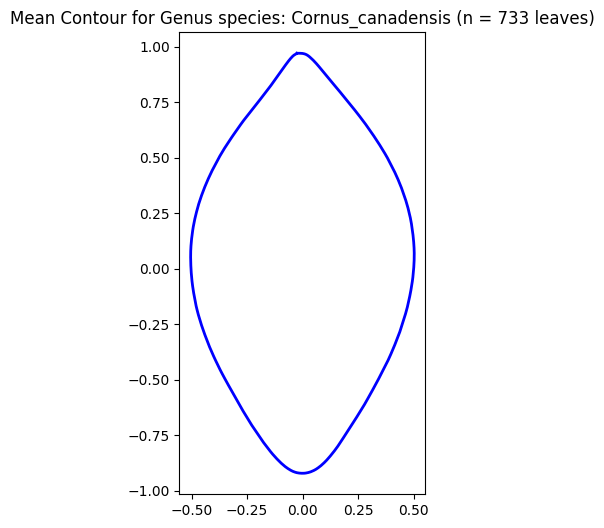

File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\USCH_1849125996_Cornaceae_Cornus_stricta__L__646-4167-1019-4699.txt
Mean Contour Shape: (1000, 2)
Mean Contour First 5 Points: [[-0.01802595  0.9651417 ]
 [-0.02165135  0.96204824]
 [-0.02562583  0.96015767]
 [-0.02923382  0.95782285]
 [-0.03251681  0.95513055]]


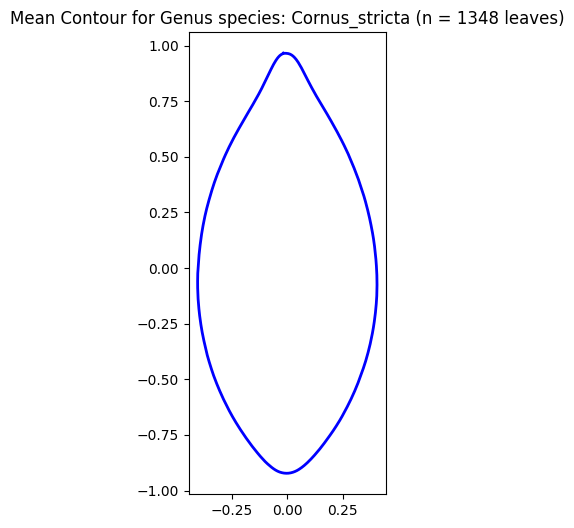

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Helper function to interpolate a contour to a fixed number of points
def interpolate_contour(points, num_points=100):
    """
    Interpolate the contour to ensure all contours have the same number of points.
    """
    # Calculate cumulative distance along the contour
    distances = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    distances = np.insert(distances, 0, 0)  # Add the first point distance (0)

    # Ensure there is variation in the contour before interpolating
    if distances[-1] == 0:
        print("Warning: No variation in contour points, skipping interpolation.")
        return points[:num_points]  # Return a default number of points

    # Interpolation functions for x and y
    interp_x = interp1d(distances, points[:, 0], kind='linear')
    interp_y = interp1d(distances, points[:, 1], kind='linear')

    # Create new distance values to interpolate
    new_distances = np.linspace(0, distances[-1], num_points)

    # Interpolate new x and y values
    new_points = np.vstack((interp_x(new_distances), interp_y(new_distances))).T

    return new_points

# Function to compute the mean contour from a filtered subset
def compute_mean_contour(df_subset, num_points=100, use_scaled=False):
    contours = []

    # Iterate through the subset and collect scaled and centered contours
    for idx, row in df_subset.iterrows():
        component_name = row['component_name']
        txt_file_path = os.path.join(outline_path, f'{component_name}.txt')

        if not os.path.exists(txt_file_path):
            print(f"File not found: {txt_file_path}")
            continue

        # Read the data from the file
        with open(txt_file_path, 'r') as file:
            lines = file.readlines()

        # Parse the max_extent and CF from the file
        max_extent = float(lines[3].strip())  # max_extent
        CF = float(lines[2].strip())  # Conversion factor (pixels per mm)

        # Use conversion_mean if available, otherwise predicted_conversion_factor_cm
        if np.isnan(row['conversion_mean']) or row['conversion_mean'] == 0:
            conversion_factor = row['predicted_conversion_factor_cm']
        else:
            conversion_factor = row['conversion_mean']

        # Starting from line 11, parse the points (x, y)
        points = []
        for line in lines[11:]:
            x_str, y_str = line.strip().split(',')
            x = float(x_str)
            y = float(y_str)
            points.append((x, y))

        # Convert to a NumPy array
        points_np = np.array(points, dtype=np.float32)

        if use_scaled:
            # Apply scaling: Multiply by max_extent, divide by conversion_factor (CF)
            points_scaled = points_np * max_extent / conversion_factor

            # Centering the points around the origin
            centroid = np.mean(points_scaled, axis=0)
            points_processed = points_scaled - centroid  # Center about the origin
        else:
            # Normalizing the points by the max extent to avoid scaling
            centroid = np.mean(points_np, axis=0)
            points_processed = points_np - centroid  # Center about the origin
            max_distance = np.max(np.linalg.norm(points_processed, axis=1))

            if max_distance > 0:  # Check if max_distance is non-zero
                points_processed /= max_distance  # Normalize to unit size
            else:
                print(f"Warning: max_distance is 0 for contour {component_name}, skipping normalization.")
                continue  # Skip the degenerate contour

        # Interpolate the contour to have a consistent number of points
        points_interpolated = interpolate_contour(points_processed, num_points=num_points)

        # Add the interpolated contour to the list
        contours.append(points_interpolated)

    # Check if we have any contours to compute mean contour
    if not contours:
        print("No valid contours to compute the mean.")
        return None

    # Compute the mean contour by averaging all x and y values
    mean_contour = np.mean(np.array(contours), axis=0)

    # Debugging: Check the mean contour values
    print("Mean Contour Shape:", mean_contour.shape)
    print("Mean Contour First 5 Points:", mean_contour[:5])

    return mean_contour

# Function to plot the mean contour with additional data in the title
def plot_mean_contour(mean_contour, taxa, n):
    plt.figure(figsize=(6, 6))

    # Check if mean_contour exists
    if mean_contour is not None:
        plt.plot(mean_contour[:, 0], mean_contour[:, 1], 'b-', linewidth=2)
        plt.title(f'Mean Contour for {taxa} (n = {n} leaves)')
        plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal
        plt.show()
    else:
        print("No contour to plot.")

# Function to filter cleaned_df, compute mean contour, and plot with title
def compute_and_plot_mean_contour(cleaned_df, family=None, genus=None, genus_species=None, fullname=None, num_points=500, use_scaled=False):
    df_subset = cleaned_df.copy()

    # Apply filtering based on input parameters
    if family:
        df_subset = df_subset[df_subset['family'] == family]
        taxa = f"Family: {family}"
    elif genus:
        df_subset = df_subset[df_subset['genus'] == genus]
        taxa = f"Genus: {genus}"
    elif genus_species:
        df_subset = df_subset[df_subset['genus_species'] == genus_species]
        taxa = f"Genus species: {genus_species}"
    elif fullname:
        df_subset = df_subset[df_subset['fullname'] == fullname]
        taxa = f"Fullname: {fullname}"
    else:
        taxa = "Unknown taxa"

    # Check if any rows match the filter
    if df_subset.empty:
        print(f"No data matches the selected filter. {taxa}")
        return

    # Get the number of leaves
    n_leaves = len(df_subset)

    # Compute the mean contour
    mean_contour = compute_mean_contour(df_subset, num_points=num_points, use_scaled=use_scaled)

    # Plot the mean contour with additional data in the title
    plot_mean_contour(mean_contour, taxa, n_leaves)


# Example usage: Compute and plot the mean contour for a given subset
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, family='Fagaceae')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Notholithocarpus_densiflorus')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Quercus_alba')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Quercus_gambelii')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Quercus_macrocarpa')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Quercus_velutina')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Ginkgoaceae_Ginkgo_biloba')

# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Populus')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Liquidambar')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Liriodendron')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Morus')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Acer')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus_species='Acer_rubrum')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus_species='Acer_saccharum')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Salix')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus_species='Tussilago_farfara')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, family='Magnoliaceae')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, family='Asteraceae')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Rhamnaceae_Rhamnus_cathartica')

compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus_species='Cornus_canadensis')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus_species='Cornus_stricta')

File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_2573014240_Cornaceae_Cornus_canadensis__L__348-2396-1429-3593.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970637047_Cornaceae_Cornus_canadensis__L__289-1793-1111-2526.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970637047_Cornaceae_Cornus_canadensis__L__813-1294-1599-2341.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970670363_Cornaceae_Cornus_canadensis__L__1006-1972-3013-3035.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970674353_Cornaceae_Cornus_canadensis__L__1908-745-2824-2566.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_3970674353_Cornaceae_Cornus_canadensis__L__974-1732-1825-2569.txt
File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\VT_4454140331_Cornaceae_Cornus_canadensis__L__744-375-1554-1

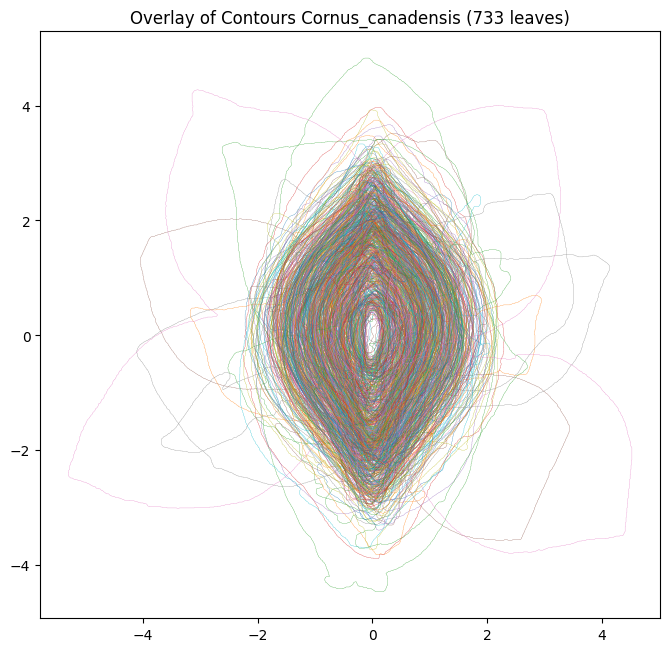

File not found: D:/D_Desktop/LM2_parallel_test_2000_Cornales/Simple_Labels\USCH_1849125996_Cornaceae_Cornus_stricta__L__646-4167-1019-4699.txt


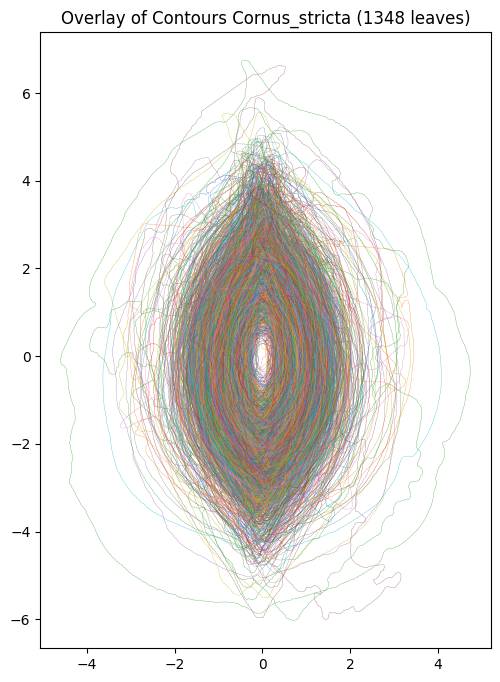

In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the outline path

# Function to read and overlay multiple contours with scaling based on conversion_mean or predicted_conversion_factor_cm
def visualize_contours_overlay_scaled(df_subset, title_name):
    plt.figure(figsize=(8, 8))
    
    # Iterate through the subset and plot each contour
    for idx, row in df_subset.iterrows():
        component_name = row['component_name']
        txt_file_path = os.path.join(outline_path, f'{component_name}.txt')
        
        if not os.path.exists(txt_file_path):
            print(f"File not found: {txt_file_path}")
            continue

        # Read the data from the file
        with open(txt_file_path, 'r') as file:
            lines = file.readlines()

        # Parse the max_extent and CF from the file
        max_extent = float(lines[3].strip())  # max_extent
        CF = float(lines[2].strip())  # Conversion factor (pixels per mm)

        # Use conversion_mean if available, otherwise predicted_conversion_factor_cm
        if np.isnan(row['conversion_mean']) or row['conversion_mean'] == 0:
            conversion_factor = row['predicted_conversion_factor_cm']
        else:
            conversion_factor = row['conversion_mean']
        # print(conversion_factor)

        # Starting from line 11, parse the points (x, y)
        points = []
        for line in lines[11:]:
            x_str, y_str = line.strip().split(',')
            x = float(x_str)
            y = float(y_str)
            points.append((x, y))

        # Convert to a NumPy array for scaling and centering
        points_np = np.array(points, dtype=np.float32)

        # Apply scaling: Multiply by max_extent, divide by conversion_factor (CF)
        points_scaled = points_np * max_extent / conversion_factor

        # Centering the points around the origin
        centroid = np.mean(points_scaled, axis=0)
        points_scaled_centered = points_scaled - centroid  # Center about the origin

        # Plot the scaled and centered contour points
        plt.plot(points_scaled_centered[:, 0], points_scaled_centered[:, 1], linewidth=0.2)

    plt.title(f'Overlay of Contours {title_name} ({len(df_subset)} leaves)')
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal
    plt.show()

# Function to filter cleaned_df based on user input and visualize
def overlay_outlines_by_filter_scaled(cleaned_df, family=None, genus=None, genus_species=None, fullname=None):
    df_subset = cleaned_df.copy()
    title_name = None

    # Apply filtering based on input parameters
    if family:
        df_subset = df_subset[df_subset['family'] == family]
        title_name = family
    if genus:
        df_subset = df_subset[df_subset['genus'] == genus]
        title_name = genus
    if genus_species:
        df_subset = df_subset[df_subset['genus_species'] == genus_species]
        title_name = genus_species
    if fullname:
        df_subset = df_subset[df_subset['fullname'] == fullname]
        title_name = fullname

    # Check if any rows match the filter
    if df_subset.empty:
        print("No data matches the selected filter.")
        return

    # Visualize the contours for the filtered subset
    visualize_contours_overlay_scaled(df_subset, title_name)

# Example usage: Overlay all outlines for a given filter
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Populus')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Morus')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Quercus')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Acer')
# overlay_outlines_by_filter_scaled(cleaned_df, genus_species='Quercus_alba')
# overlay_outlines_by_filter_scaled(cleaned_df, genus_species='Quercus_glauca')
# overlay_outlines_by_filter_scaled(cleaned_df, family='Asteraceae')

# overlay_outlines_by_filter_scaled(cleaned_df, family='Fagaceae')
# overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Notholithocarpus_densiflorus')
# overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Quercus_alba')
# overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Quercus_gambelii')
# overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Quercus_macrocarpa')
# overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Quercus_velutina')
# overlay_outlines_by_filter_scaled(cleaned_df, fullname='Ginkgoaceae_Ginkgo_biloba')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Populus')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Liquidambar')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Liriodendron')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Morus')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Acer')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Salix')
# overlay_outlines_by_filter_scaled(cleaned_df, genus_species='Tussilago_farfara')
# overlay_outlines_by_filter_scaled(cleaned_df, family='Magnoliaceae')
# overlay_outlines_by_filter_scaled(cleaned_df, family='Asteraceae')
# overlay_outlines_by_filter_scaled(cleaned_df, fullname='Rhamnaceae_Rhamnus_cathartica')

overlay_outlines_by_filter_scaled(cleaned_df, genus_species='Cornus_canadensis')
overlay_outlines_by_filter_scaled(cleaned_df, genus_species='Cornus_stricta')

In [74]:
import numpy as np
from scipy.spatial import distance_matrix
import time

# Generate random data (simulating your ECT data)
n_samples = 10000  # Number of samples
n_features = 500   # Number of features (flattened ECT)

# Generate random data
data = np.random.rand(n_samples, n_features)

# # Measure time for SciPy distance_matrix (CPU-based)
# start_time = time.time()
# D_scipy = distance_matrix(data, data)
# end_time = time.time()

# print(f"Time taken by SciPy (CPU): {end_time - start_time:.4f} seconds")

import torch
import time

# Convert the same data to a PyTorch tensor on GPU
data_gpu = torch.tensor(data, dtype=torch.float32, device='cuda')

# Define the pairwise distance function
def torch_distance_matrix(X):
    G = torch.mm(X, X.T)  # Gram matrix (X @ X.T)
    H = torch.diag(G).unsqueeze(0)  # Diagonal of Gram matrix
    D = torch.sqrt(H.T + H - 2 * G)  # Pairwise Euclidean distances
    return D

# Measure time for PyTorch (GPU-based)
start_time = time.time()
D_torch = torch_distance_matrix(data_gpu)
print(D_torch)
end_time = time.time()

print(f"Time taken by PyTorch (GPU): {end_time - start_time:.4f} seconds")


tensor([[0.0000, 8.9797, 8.9120,  ..., 9.2816, 8.7884, 8.9658],
        [8.9797, 0.0000, 9.3270,  ..., 8.9911, 9.1099, 8.8175],
        [8.9120, 9.3270, 0.0000,  ..., 9.1751, 9.2755, 8.9856],
        ...,
        [9.2816, 8.9911, 9.1751,  ..., 0.0000, 9.4635, 9.2260],
        [8.7884, 9.1099, 9.2755,  ..., 9.4635, 0.0000, 9.3352],
        [8.9658, 8.8175, 8.9856,  ..., 9.2260, 9.3352, 0.0000]],
       device='cuda:0')
Time taken by PyTorch (GPU): 0.2290 seconds
